In [2]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.data_processing import *
from src.data.data_fetching import *
from src.data.data_processing_lagged import *
from src.models.predict_model_lagged import *

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Benchmark Models
Try other models to compare to LSTM for Shasta Reservoir.

## Data Processing and Add Lags
Create train/val/test split. Add five autoregressive lags as columns.

In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

In [4]:
# Run data processing pipeline
pipeline = processing_pipeline_w_lags(df=df, n_lags=5, exclude_list=['outflow', 'storage', 'doy'])
df_train, df_val, df_test = pipeline.process_data()

In [5]:
pipeline.scaler.feature_names_in_

array(['inflow', 'outflow', 'storage', 'doy', 'inflow_lag1',
       'inflow_lag2', 'inflow_lag3', 'inflow_lag4', 'inflow_lag5'],
      dtype=object)

In [6]:
# Separate features (X) and targets (y)
X_train, X_val, X_test = df_train[:, np.r_[0, 3:9]], df_val[:, np.r_[0, 3:9]], df_test[:, np.r_[0, 3:9]]
y_train, y_val, y_test = df_train[:, 1], df_val[:, 1], df_test[:, 1]

## Fit Models

### Linear Model

In [7]:
# Train model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

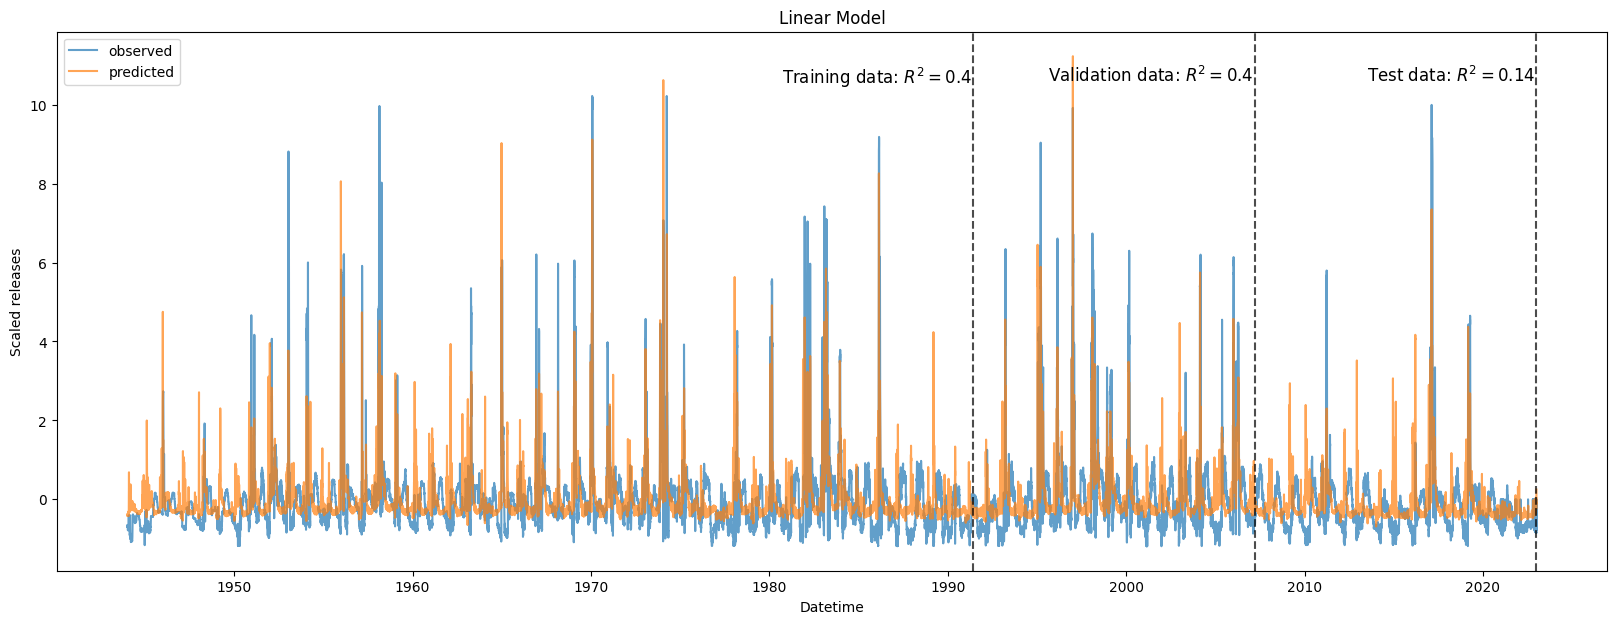

In [8]:
# Plot results
fig, ax = plt.subplots(figsize=(20, 7))
plot_lagged_model(model=linear_model, X_train=X_train, X_val=X_val, X_test=X_test,
                  y_train=y_train, y_val=y_val, y_test=y_test, datetime_index=pipeline.df_lagged.index, 
                  ax=ax, text_ypos=11, alpha=0.7)
ax.set_title('Linear Model')
plt.show()

### Random Forest Model

In [9]:
# Train a model
rf_model = RandomForestRegressor(max_depth=5)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

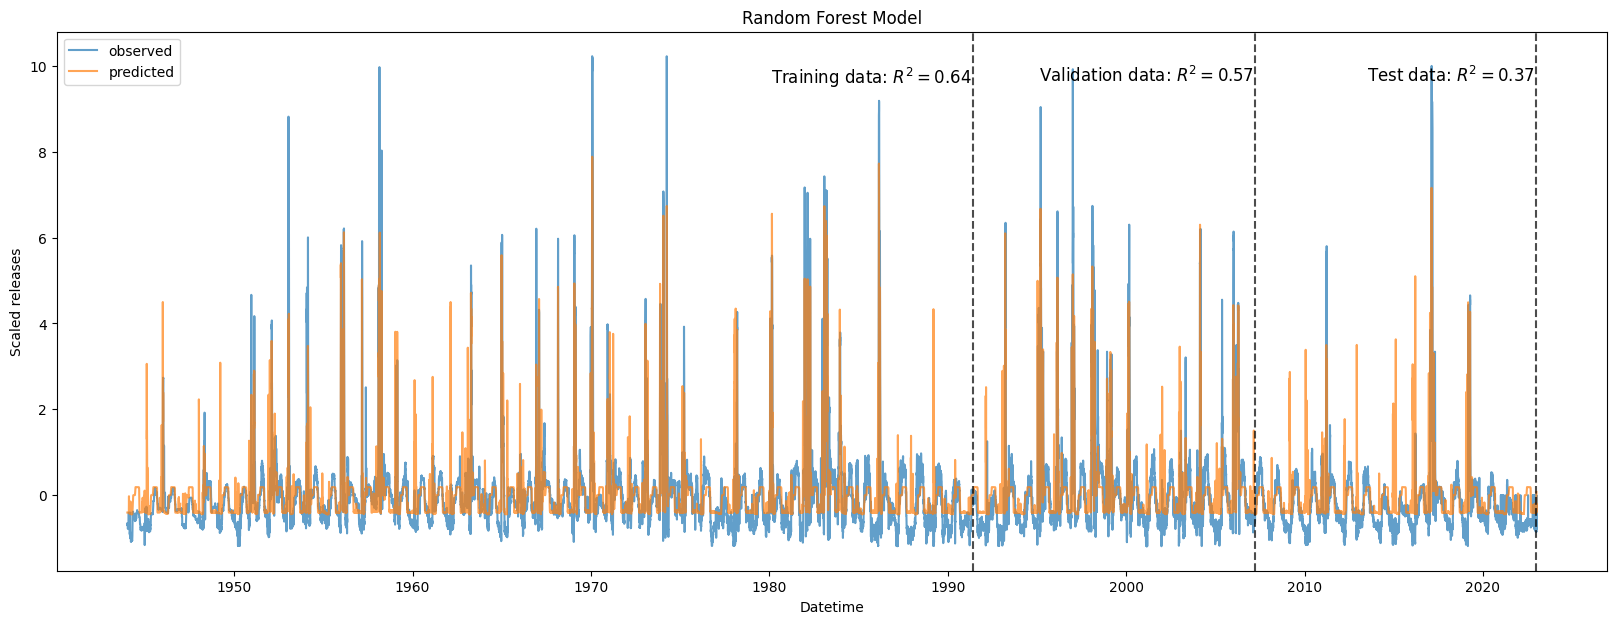

In [10]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_lagged_model(model=rf_model, X_train=X_train, X_val=X_val, X_test=X_test,
                  y_train=y_train, y_val=y_val, y_test=y_test, datetime_index=pipeline.df_lagged.index, 
                  ax=ax, text_ypos=10, alpha=0.7)
ax.set_title('Random Forest Model')
plt.show()

Both the linear model and the random forest model tend to overpredict the number of peaks compared to the LSTM models.

## What if storage information is known?

In [11]:
# Separate features (X) and targets (y)
X_train_stg, X_val_stg, X_test_stg = df_train[:, np.r_[0, 2:9]], df_val[:, np.r_[0, 2:9]], df_test[:, np.r_[0, 2:9]]
y_train_stg, y_val_stg, y_test_stg = df_train[:, 1], df_val[:, 1], df_test[:, 1]

### Linear Model (known storage)

In [12]:
linear_model_stg = LinearRegression()
linear_model_stg.fit(X_train_stg, y_train_stg)

LinearRegression()

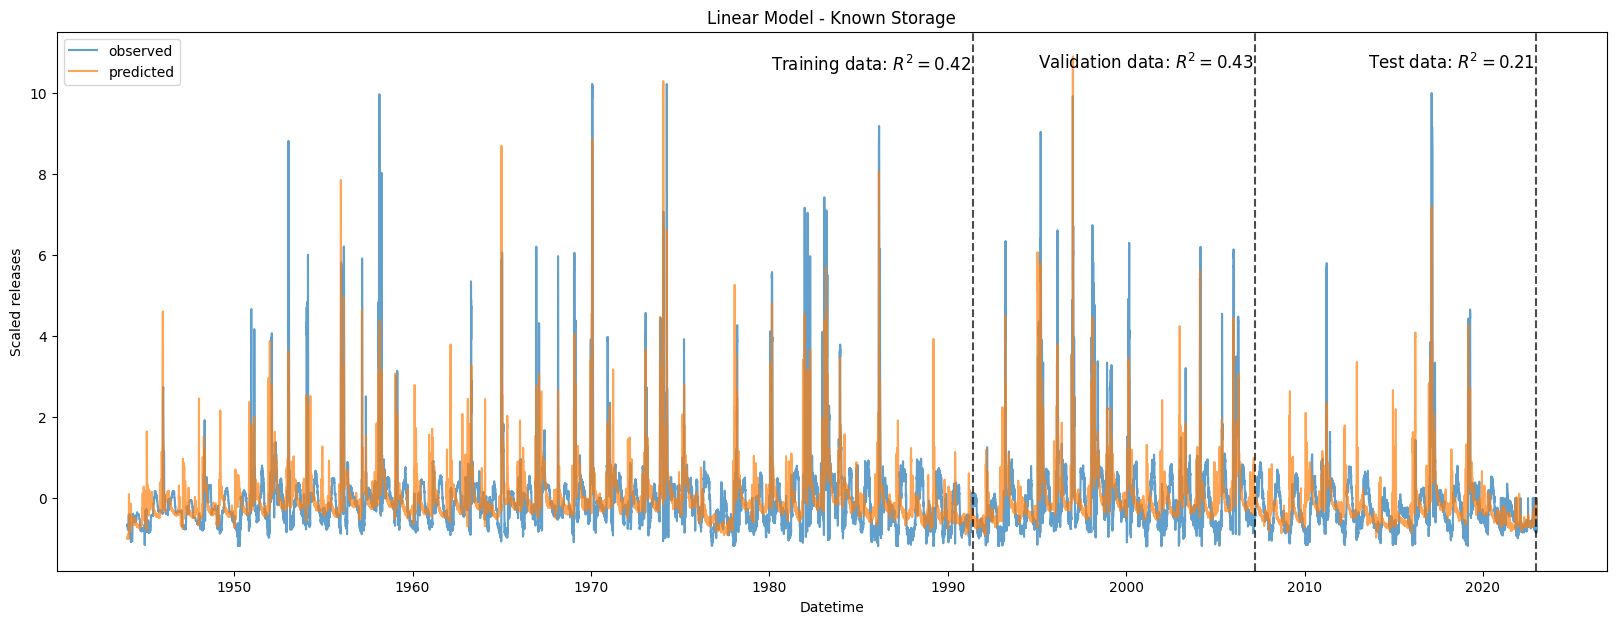

In [13]:
# Plot results
fig, ax = plt.subplots(figsize=(20, 7))
plot_lagged_model(model=linear_model_stg, X_train=X_train_stg, X_val=X_val_stg, X_test=X_test_stg,
                  y_train=y_train_stg, y_val=y_val_stg, y_test=y_test_stg, datetime_index=pipeline.df_lagged.index, 
                  ax=ax, text_ypos=11, alpha=0.7)
ax.set_title('Linear Model - Known Storage')
plt.show()

### Random Forest (Known Storage)

In [14]:
rf_model_stg = RandomForestRegressor(max_depth=5)
rf_model_stg.fit(X_train_stg, y_train_stg)

RandomForestRegressor(max_depth=5)

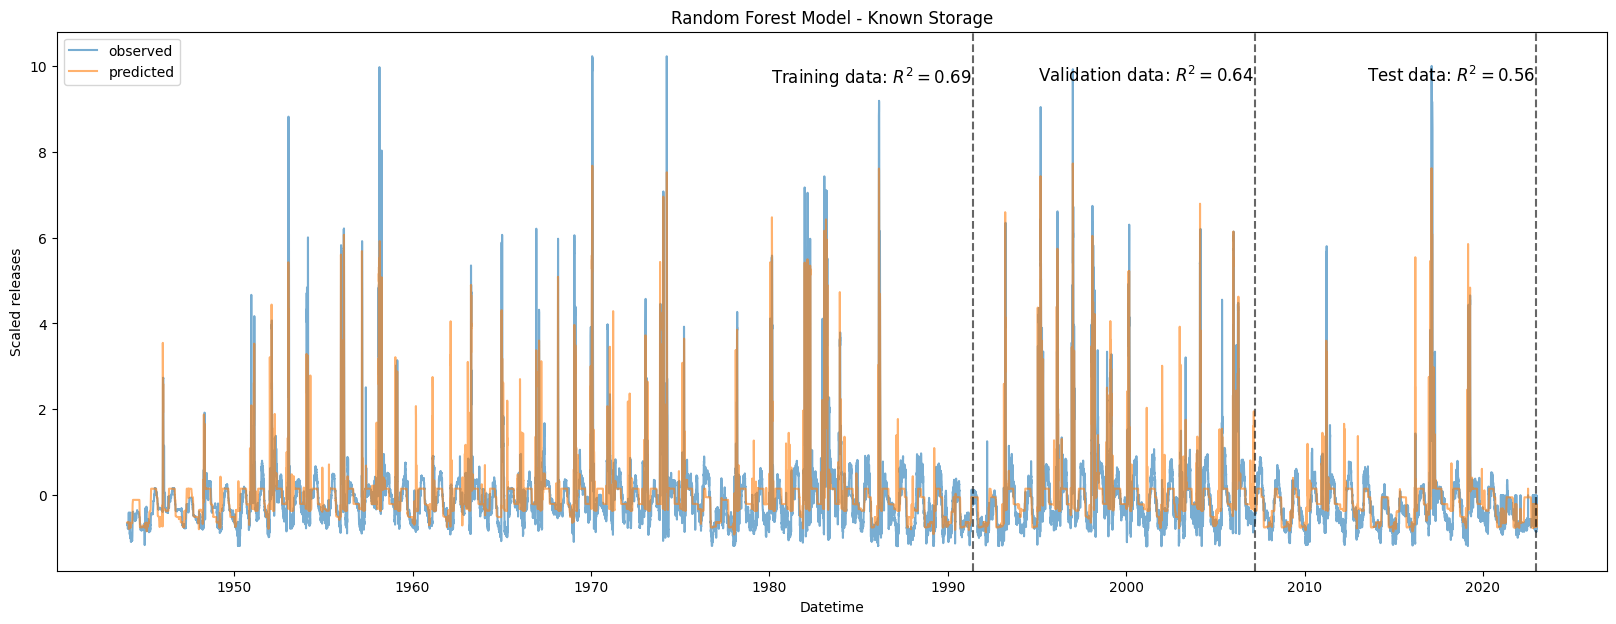

In [15]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_lagged_model(model=rf_model_stg, X_train=X_train_stg, X_val=X_val_stg, X_test=X_test_stg,
                  y_train=y_train_stg, y_val=y_val_stg, y_test=y_test_stg, datetime_index=pipeline.df_lagged.index, 
                  ax=ax, text_ypos=10, alpha=0.6)
ax.set_title('Random Forest Model - Known Storage')
plt.show()

There is a notable improvement, especially for the random forest model. The seasonal releases appear to have adapted to the available storage.

# Rule Based Model

In [6]:
from ssjrb_wrapper.model_wrapper import reservoir_model
from ssjrb_wrapper.util import read_historical_df
from ssjrb_wrapper.util import water_day
from ssjrb_wrapper.train_preprocess import train_medians

In [7]:
def fit_one_reservoir(name, left, right = '2022-12-31'):
    """
    Fit SSJRB reservoir model to a single reservoir for USBR data

    Params:
    res_id -- str, Reservoir ID to fit model to
    left -- str (datelike), left window date to fetch data from
    right -- str (datelike), right window date to fetch data from

    Returns:
    model -- fitted SSJRB model
    r2_scores -- df of outflow r2 scores for train/val/test splits
    """

    ### DATA PROCESSING

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Select left-right window
    df = df[left:right].copy()

    # Rename columns to work with SSJRB wrapper
    df[f'{name}_inflow_cfs'] = df['inflow']
    df[f'{name}_outflow_cfs'] = df['outflow']
    df[f'{name}_storage_af'] = df['storage']

    # Add DOWY column
    doy_series = df.index.to_series().dt.dayofyear
    df['dowy'] = [water_day(i) for i in doy_series]

    # Train/val/test split
    df_train, df_val, df_test = train_val_test(df, train_frac=0.6, val_frac=0.2, test_frac=0.2)

    # Fill missing values with mean of training data
    train_mean = df_train.mean()
    df_train = df_train.fillna(train_mean)
    df_val = df_val.fillna(train_mean)
    df_test = df_test.fillna(train_mean)


    ### MODEL TRAINING

    # Capacity (take as max of training storage series)
    training_capacity = df_train[f'{name}_storage_af'].max() / 1000 # units = TAF
    capacity_dict = {name: training_capacity}

    # Instantiate model
    model_i = reservoir_model(reservoir_capacity = capacity_dict)
    # Fit with early stopping on validation data
    model_i.fit(df_train=df_train, df_val=df_val, patience=5)

    ### EVALUATE MODEL AND SAVE PARAMS

    # Get predictions from fitted model, evaluate r2 score
    df_hat_train, df_hat_val, df_hat_test = (model_i.predict(df = df_train),
                                            model_i.predict(df = df_val),
                                            model_i.predict(df = df_test))

    r2_scores = pd.DataFrame({'train': r2_score(df_train[f'{name}_outflow_cfs'], df_hat_train[f'{name}_outflow_cfs']),
                            'val': r2_score(df_val[f'{name}_outflow_cfs'], df_hat_val[f'{name}_outflow_cfs']),
                            'test': r2_score(df_test[f'{name}_outflow_cfs'], df_hat_test[f'{name}_outflow_cfs'])}, index=[name])

    # # Save model parameters
    # model_i.save_params(filepath='./results/saved_models/resops_ssjrb_reservoir', fileprefix=f'resops_ssjrb_model_{res_id}')

    return model_i, r2_scores

In [9]:
# Fit rule based model to Shasta reservoir
rule_model, rule_r2_scores = fit_one_reservoir(name='Shasta', left='1944-01-01', right='2022-12-31')
rule_r2_scores

Shasta: train score=14226278, val score: 18017592, NFE = 1659, Message: Early stopping triggered


,train,val,test
Shasta,0.685683,0.680901,0.655923
